In [ ]:
import asyncio
import random
import time
import hashlib
from dataclasses import dataclass, field
from typing import Dict, Set, Tuple, Optional, List
import matplotlib.pyplot as plt

PREPREPARE = "PREPREPARE"
PREPARE    = "PREPARE"
COMMIT     = "COMMIT"

@dataclass(frozen=True)
class Msg:
    typ: str
    view: int
    seq: int
    digest: str
    sender: int

@dataclass
class NetConfig:
    min_delay_ms: int = 5
    max_delay_ms: int = 40
    drop_prob: float = 0.0
    reorder_prob: float = 0.0

In [ ]:
class Network:
    def __init__(self, cfg: NetConfig):
        self.cfg = cfg
        self.nodes: Dict[int, "Node"] = {}

    def register(self, node: "Node"):
        self.nodes[node.nid] = node

    async def send(self, dst: int, msg: Msg):
        if random.random() < self.cfg.drop_prob:
            return

        d = random.uniform(self.cfg.min_delay_ms, self.cfg.max_delay_ms) / 1000.0
        await asyncio.sleep(d)

        if random.random() < self.cfg.reorder_prob:
            await asyncio.sleep(random.uniform(0.0, 0.02))

        await self.nodes[dst].inbox.put(msg)

    async def broadcast(self, src: int, msg: Msg):
        tasks = []
        for nid in self.nodes.keys():
            tasks.append(asyncio.create_task(self.send(nid, msg)))
        await asyncio.gather(*tasks)

In [ ]:
@dataclass
class NodeConfig:
    n: int
    f: int
    primary_id: int = 0
    view: int = 0
    timeout_s: float = 2.0

class Node:
    def __init__(self, nid: int, net: Network, cfg: NodeConfig, byzantine: bool = False):
        self.nid = nid
        self.net = net
        self.cfg = cfg
        self.byzantine = byzantine

        self.inbox: asyncio.Queue[Msg] = asyncio.Queue()

        self.preprepare_seen: Dict[int, str] = {}
        self.prepare_votes: Dict[Tuple[int, str], Set[int]] = {}
        self.commit_votes: Dict[Tuple[int, str], Set[int]] = {}

        self.committed: Dict[int, str] = {}
        self.running = True

    @property
    def f(self) -> int:
        return self.cfg.f

    def _q_prepare(self) -> int:
        return 2 * self.f + 1

    def _q_commit(self) -> int:
        return 2 * self.f + 1

    @staticmethod
    def digest_of(payload: str) -> str:
        return hashlib.sha256(payload.encode("utf-8")).hexdigest()

In [ ]:
    async def propose(self, payload: str, seq: int):
        if self.nid != self.cfg.primary_id:
            raise ValueError("Only the primary can propose in this simplified simulator.")

        if not self.byzantine:
            dig = self.digest_of(payload)
            msg = Msg(PREPREPARE, self.cfg.view, seq, dig, self.nid)
            await self.net.broadcast(self.nid, msg)
            return

        for dst in self.net.nodes.keys():
            variant = f"{payload}::to={dst}::salt={random.randint(0,10**9)}"
            dig = self.digest_of(variant)
            msg = Msg(PREPREPARE, self.cfg.view, seq, dig, self.nid)
            await self.net.send(dst, msg)

    async def handle_preprepare(self, msg: Msg):
        seq = msg.seq
        dig = msg.digest

        if self.byzantine:
            if random.random() < 0.5:
                return
            fake_dig = dig if random.random() < 0.5 else self.digest_of(dig + "::fake")
            out = Msg(PREPARE, msg.view, seq, fake_dig, self.nid)
            await self.net.broadcast(self.nid, out)
            return

        if seq not in self.preprepare_seen:
            self.preprepare_seen[seq] = dig
            out = Msg(PREPARE, msg.view, seq, dig, self.nid)
            await self.net.broadcast(self.nid, out)

    async def handle_prepare(self, msg: Msg):
        seq, dig = msg.seq, msg.digest
        key = (seq, dig)
        voters = self.prepare_votes.setdefault(key, set())
        voters.add(msg.sender)

        if self.byzantine:
            return

        if self.preprepare_seen.get(seq) != dig:
            return

        if len(voters) >= self._q_prepare():
            out = Msg(COMMIT, msg.view, seq, dig, self.nid)
            await self.net.broadcast(self.nid, out)

    async def handle_commit(self, msg: Msg):
        seq, dig = msg.seq, msg.digest
        key = (seq, dig)
        voters = self.commit_votes.setdefault(key, set())
        voters.add(msg.sender)

        if self.byzantine:
            return

        if self.preprepare_seen.get(seq) != dig:
            return

        if seq in self.committed:
            return

        if len(voters) >= self._q_commit():
            self.committed[seq] = dig

In [ ]:
    async def run(self):
        while self.running:
            msg = await self.inbox.get()
            if msg.typ == PREPREPARE:
                await self.handle_preprepare(msg)
            elif msg.typ == PREPARE:
                await self.handle_prepare(msg)
            elif msg.typ == COMMIT:
                await self.handle_commit(msg)

    def stop(self):
        self.running = False

def pbft_params(n: int) -> int:
    return (n - 1) // 3

async def run_single_consensus(
    n: int,
    malicious: int,
    net_cfg: NetConfig,
    payload: str = "tx: pay Alice->Bob 5",
    seq: int = 1,
    timeout_s: float = 2.0,
    seed: Optional[int] = None
) -> Dict[str, object]:
    if seed is not None:
        random.seed(seed)

    f_max = pbft_params(n)
    f = f_max

    net = Network(net_cfg)
    cfg = NodeConfig(n=n, f=f, primary_id=0, view=0, timeout_s=timeout_s)

    mal_set = set(random.sample(range(n), k=min(malicious, n)))
    nodes: List[Node] = []
    for i in range(n):
        node = Node(i, net, cfg, byzantine=(i in mal_set))
        net.register(node)
        nodes.append(node)

    tasks = [asyncio.create_task(node.run()) for node in nodes]

    t0 = time.perf_counter()
    await nodes[cfg.primary_id].propose(payload, seq)

    honest = [node for node in nodes if not node.byzantine]
    target = max(1, len(honest))

    committed_honest = 0
    latency = None

    async def poll_commits():
        nonlocal committed_honest, latency
        while True:
            committed_honest = sum(1 for node in honest if seq in node.committed)
            if committed_honest >= target:
                latency = time.perf_counter() - t0
                return
            await asyncio.sleep(0.005)

    try:
        await asyncio.wait_for(poll_commits(), timeout=timeout_s)
        success = True
    except asyncio.TimeoutError:
        success = False
        latency = None

    for node in nodes:
        node.stop()
    for task in tasks:
        task.cancel()
    await asyncio.gather(*tasks, return_exceptions=True)

    digest_set = set(node.committed.get(seq) for node in honest if seq in node.committed)
    agreed = (len(digest_set) == 1) if success else False

    return {
        "n": n,
        "f": f,
        "malicious": malicious,
        "mal_set": mal_set,
        "success": success,
        "latency_s": latency,
        "honest_committed": committed_honest,
        "honest_total": len(honest),
        "agreed_digest": agreed,
    }

n=10 => PBFT theoretical max f = floor((n-1)/3) = 3
Theory: safety/liveness typically assumed when malicious <= f and timing assumptions hold.

malicious= 0 | success=6/6 | avg_latency=0.21820481133333658 | digest_agreement=6/6
malicious= 1 | success=6/6 | avg_latency=0.18737508766666622 | digest_agreement=6/6
malicious= 2 | success=4/6 | avg_latency=0.15154795675000088 | digest_agreement=4/4
malicious= 3 | success=3/6 | avg_latency=0.1331977223333259 | digest_agreement=3/3
malicious= 4 | success=0/6 | avg_latency=NA | digest_agreement=0/1
malicious= 5 | success=0/6 | avg_latency=NA | digest_agreement=0/1
malicious= 6 | success=0/6 | avg_latency=NA | digest_agreement=0/1
malicious= 7 | success=0/6 | avg_latency=NA | digest_agreement=0/1
malicious= 8 | success=0/6 | avg_latency=NA | digest_agreement=0/1
malicious= 9 | success=0/6 | avg_latency=NA | digest_agreement=0/1


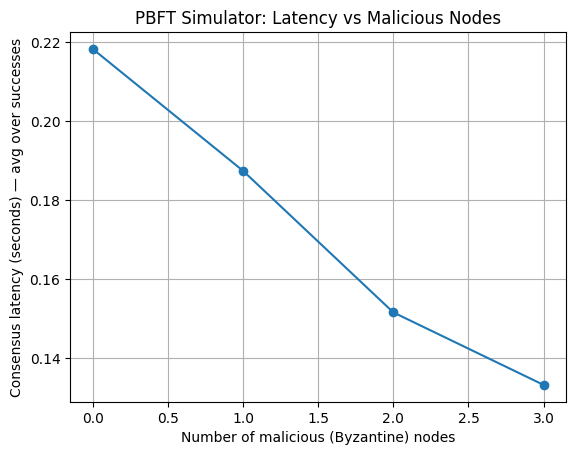

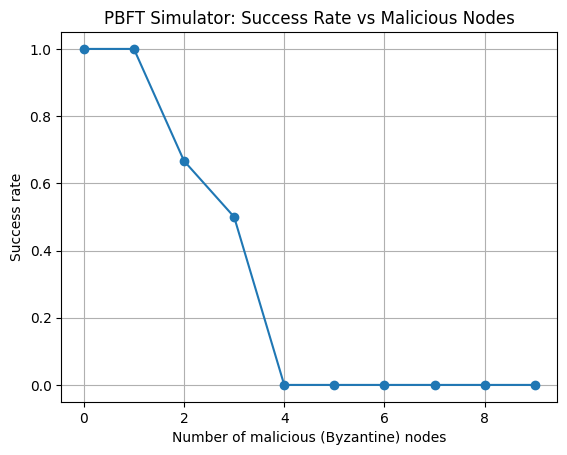

In [1]:
async def latency_sweep(
    n: int = 10,
    max_malicious: Optional[int] = None,
    trials_per_point: int = 5,
    timeout_s: float = 2.0,
    net_cfg: Optional[NetConfig] = None,
    seed: int = 7
):
    if net_cfg is None:
        net_cfg = NetConfig(min_delay_ms=5, max_delay_ms=35, drop_prob=0.0, reorder_prob=0.05)

    if max_malicious is None:
        max_malicious = n

    results = []
    random.seed(seed)

    for m in range(0, max_malicious + 1):
        latencies = []
        successes = 0
        agreements = 0

        for t in range(trials_per_point):
            out = await run_single_consensus(
                n=n,
                malicious=m,
                net_cfg=net_cfg,
                timeout_s=timeout_s,
                seed=seed + 1000*m + t
            )
            results.append(out)
            if out["success"]:
                successes += 1
                latencies.append(out["latency_s"])
                if out["agreed_digest"]:
                    agreements += 1

        avg_lat = sum(latencies)/len(latencies) if latencies else None
        print(
            f"malicious={m:2d} | success={successes}/{trials_per_point} "
            f"| avg_latency={avg_lat if avg_lat is not None else 'NA'} "
            f"| digest_agreement={agreements}/{successes if successes else 1}"
        )

    return results

def plot_latency(results: List[Dict[str, object]], trials_per_point: int):
    by_m = {}
    for r in results:
        m = r["malicious"]
        by_m.setdefault(m, []).append(r)

    xs, ys = [], []
    success_rate = []
    for m in sorted(by_m.keys()):
        group = by_m[m]
        lats = [g["latency_s"] for g in group if g["latency_s"] is not None]
        succ = sum(1 for g in group if g["success"])
        xs.append(m)
        ys.append(sum(lats)/len(lats) if lats else float("nan"))
        success_rate.append(succ / len(group))

    plt.figure()
    plt.plot(xs, ys, marker="o")
    plt.xlabel("Number of malicious (Byzantine) nodes")
    plt.ylabel("Consensus latency (seconds) — avg over successes")
    plt.title("PBFT Simulator: Latency vs Malicious Nodes")
    plt.grid(True)
    plt.show()

    plt.figure()
    plt.plot(xs, success_rate, marker="o")
    plt.xlabel("Number of malicious (Byzantine) nodes")
    plt.ylabel("Success rate")
    plt.title("PBFT Simulator: Success Rate vs Malicious Nodes")
    plt.ylim(-0.05, 1.05)
    plt.grid(True)
    plt.show()

async def main():
    n = 10
    trials = 6
    f = pbft_params(n)
    print(f"n={n} => PBFT theoretical max f = floor((n-1)/3) = {f}")
    print("Theory: safety/liveness typically assumed when malicious <= f and timing assumptions hold.\n")

    results = await latency_sweep(
        n=n,
        max_malicious=min(n, f + 6),
        trials_per_point=trials,
        timeout_s=2.0,
        net_cfg=NetConfig(min_delay_ms=5, max_delay_ms=35, drop_prob=0.0, reorder_prob=0.05),
        seed=11
    )
    plot_latency(results, trials)

await main()